# Health Recommender System for Cervical Cancer Prognosis in Women!
The goal of this note book is to replicate the research done by the paper with the same name 
Overall some notes in implemenatation:
- SMOTE has to be used to balance the training data set
- Used different machines learning models for this dataset
- Biopsy is used as the target class
- Use MOGA(Multi-Objective Genetic Algorithm to narrow down the feature sets --- Later) 

Cited paper:
Kuanr, Madhusree, et al. “Health Recommender System for Cervical Cancer Prognosis in Women.” 2021 6th International Conference on Inventive Computation Technologies (ICICT), Inventive Computation Technologies (ICICT), 2021 6th International Conference On, Jan. 2021, pp. 673–79. EBSCOhost, https://doi-org.ezproxy.mtsu.edu/10.1109/ICICT50816.2021.9358540.

In [1]:
import plotly.io as pio
pio.renderers.default = "notebook+pdf"

In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

In [5]:
from catboost import CatBoostClassifier
from catboost import Pool

def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1000,
        use_best_model= True,
        #task_type='GPU'
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [6]:
df=pd.read_csv("./data/kag_risk_factors_cervical_cancer.csv")
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [7]:
target = 'Biopsy'

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

Remove duplicates

In [9]:
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 835 non-null    int64 
 1   Number of sexual partners           835 non-null    object
 2   First sexual intercourse            835 non-null    object
 3   Num of pregnancies                  835 non-null    object
 4   Smokes                              835 non-null    object
 5   Smokes (years)                      835 non-null    object
 6   Smokes (packs/year)                 835 non-null    object
 7   Hormonal Contraceptives             835 non-null    object
 8   Hormonal Contraceptives (years)     835 non-null    object
 9   IUD                                 835 non-null    object
 10  IUD (years)                         835 non-null    object
 11  STDs                                835 non-null    object

# Preprocessing

Replace "?" with the median for all columns.

In [10]:
df = df.replace('?', np.nan)

print("Check all Nan counts")
df.isnull().sum()

Check all Nan counts


Age                                     0
Number of sexual partners              25
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               103
Hormonal Contraceptives (years)       103
IUD                                   112
IUD (years)                           112
STDs                                  100
STDs (number)                         100
STDs:condylomatosis                   100
STDs:cervical condylomatosis          100
STDs:vaginal condylomatosis           100
STDs:vulvo-perineal condylomatosis    100
STDs:syphilis                         100
STDs:pelvic inflammatory disease      100
STDs:genital herpes                   100
STDs:molluscum contagiosum            100
STDs:AIDS                             100
STDs:HIV                              100
STDs:Hepatitis B                  

In [11]:
df=df._convert(numeric=True)
df = df.fillna(df.median())

print("Check all Nan counts")
df.isnull().sum()

Check all Nan counts


Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


Other tasks
- Since Hinselmann, Schiller, Citology, Biopsy are all cancer test, create an aggreated group that count all of these information.
- Try to create an aggregated STD column that count all STD prediction
- Create an column for age group for easy visualization

In [12]:
#Create age group for visualization
def age_group(n):
    if n < 12:
        return "Child"
    elif n < 20:
        return "Teen"
    elif n < 30:
        return "20's"
    elif n < 40:
        return "30's"
    elif n < 50:
        return "40's"
    elif n < 60:
        return "50's"
    elif n < 70:
        return "60's"
    else:
        return "70+"

df["age_cat"] = df["Age"].apply(age_group)

In [13]:
#Aggregated std
std_cols = ['STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV']
df["total_std"] = df[list(std_cols)].sum(axis=1)
std_agg_df = df.groupby("age_cat", as_index=False)[list(std_cols)].sum()

In [14]:
#Aggregated test result:
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
df["total_tests"] = df[test_cols].sum(axis = 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 857
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 835 non-null    int64  
 1   Number of sexual partners           835 non-null    float64
 2   First sexual intercourse            835 non-null    float64
 3   Num of pregnancies                  835 non-null    float64
 4   Smokes                              835 non-null    float64
 5   Smokes (years)                      835 non-null    float64
 6   Smokes (packs/year)                 835 non-null    float64
 7   Hormonal Contraceptives             835 non-null    float64
 8   Hormonal Contraceptives (years)     835 non-null    float64
 9   IUD                                 835 non-null    float64
 10  IUD (years)                         835 non-null    float64
 11  STDs                                835 non-n

# Data Exploration

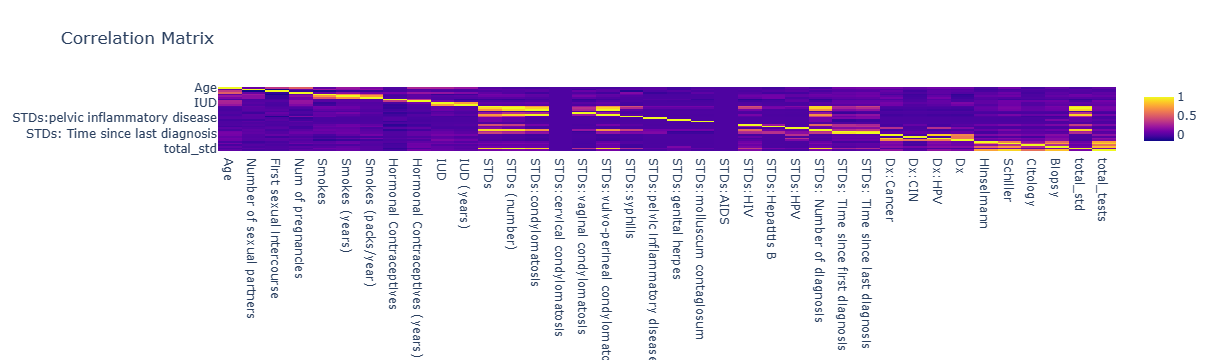

In [16]:
corr_matrix = df.corr()
corr_matrix.fillna(0,inplace=True)
corr_graph = px.imshow(corr_matrix, aspect="auto",title="Correlation Matrix")
corr_graph.show()

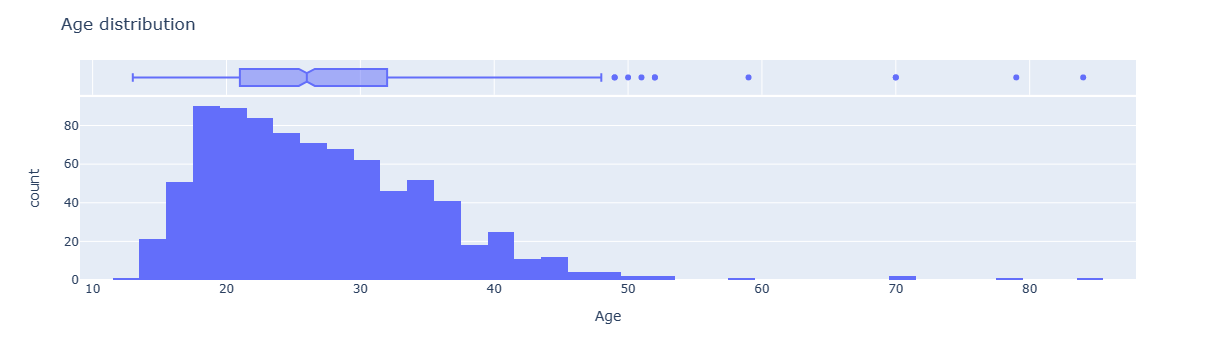

In [17]:
age_dist = px.histogram(df, x="Age", marginal="box")
age_dist.update_layout(title="Age distribution")
age_dist.show()

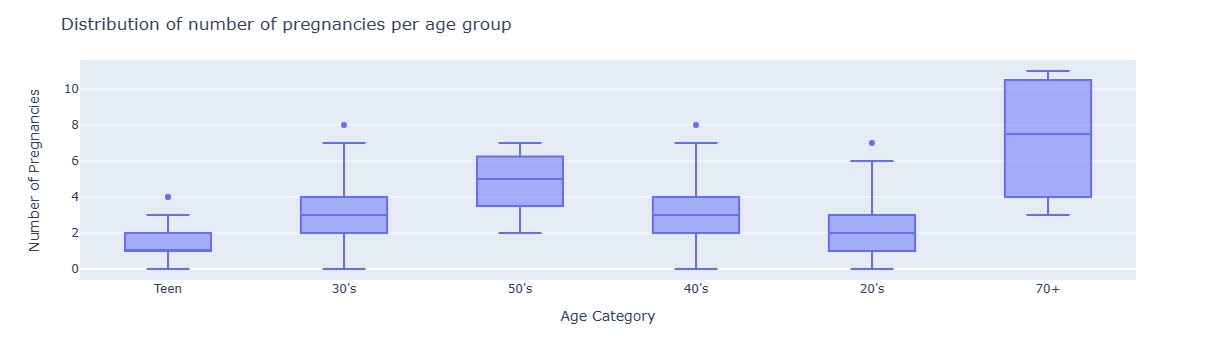

In [18]:
age_preg_bar = px.box(df, x="age_cat", y="Num of pregnancies", points="outliers",
                      category_orders=["Teenager", "Twenties", "Thirties", "Forties", "Fifties",
                                       "Seventy and over"])
age_preg_bar.update_xaxes(title="Age Category")
age_preg_bar.update_yaxes(title="Number of Pregnancies")
age_preg_bar.update_layout(title="Distribution of number of pregnancies per age group")
age_preg_bar.show()

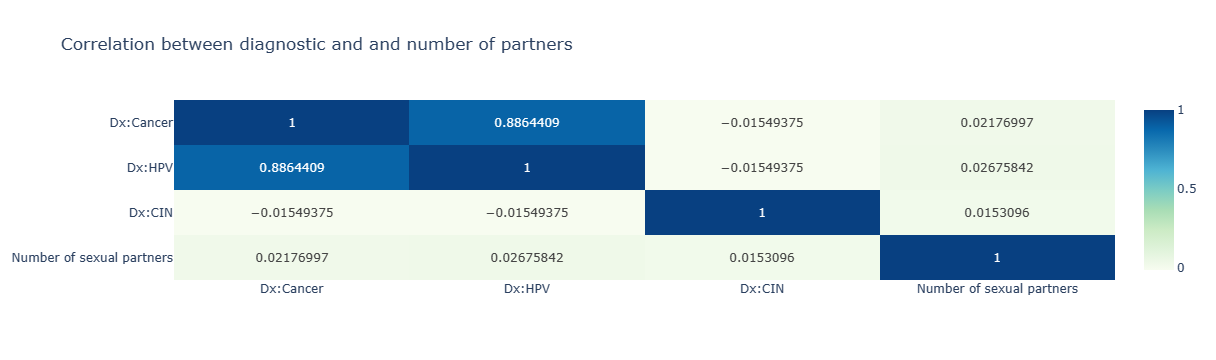

In [19]:
diagnoses_num_partner_compare_cols = ['Dx:Cancer',
                                      'Dx:HPV',
                                      'Dx:CIN',
                                      "Number of sexual partners",]
corr_matrix = df[diagnoses_num_partner_compare_cols].corr()
diagnoses_num_partner_heatmap = px.imshow(corr_matrix,
                              aspect="auto",
                              text_auto=True,
                                         title='Correlation between diagnostic and and number of partners',
                                         color_continuous_scale="gnbu")
diagnoses_num_partner_heatmap.show()

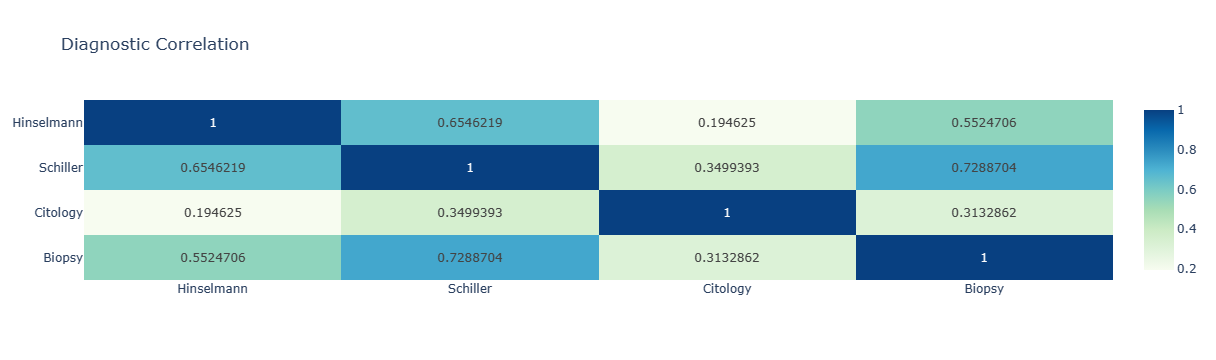

In [20]:
diagnoses_cols = ['Hinselmann','Schiller','Citology','Biopsy']
diagnoses_corr_matrix = df[diagnoses_cols].corr()
diagnoses_heatmap = px.imshow(diagnoses_corr_matrix, aspect="auto", text_auto=True,color_continuous_scale="gnbu",
                              title='Diagnostic Correlation')
diagnoses_heatmap.show()

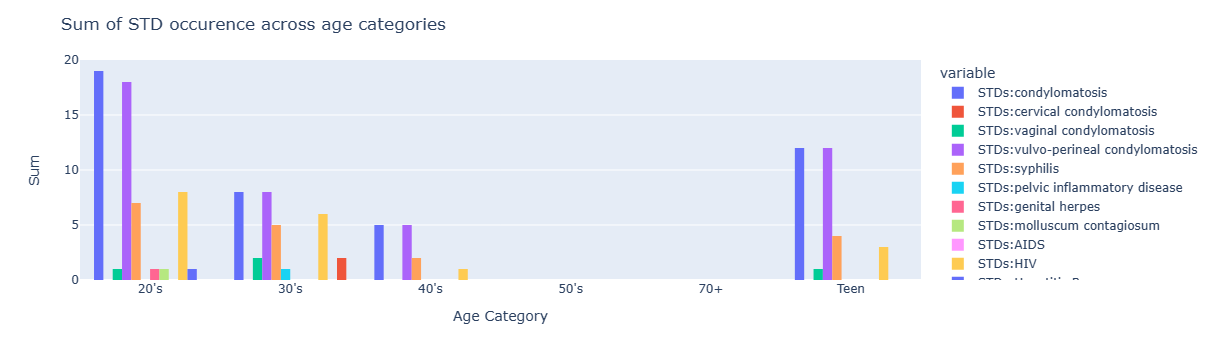

In [21]:
fig = px.histogram(std_agg_df, x="age_cat", y=list(std_cols), barmode="group", histfunc="sum")
fig.update_layout(title="Sum of STD occurence across age categories")
fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Sum")
fig.show()

# Distribution of Classes

In [22]:
df[target].value_counts()

0    781
1     54
Name: Biopsy, dtype: int64

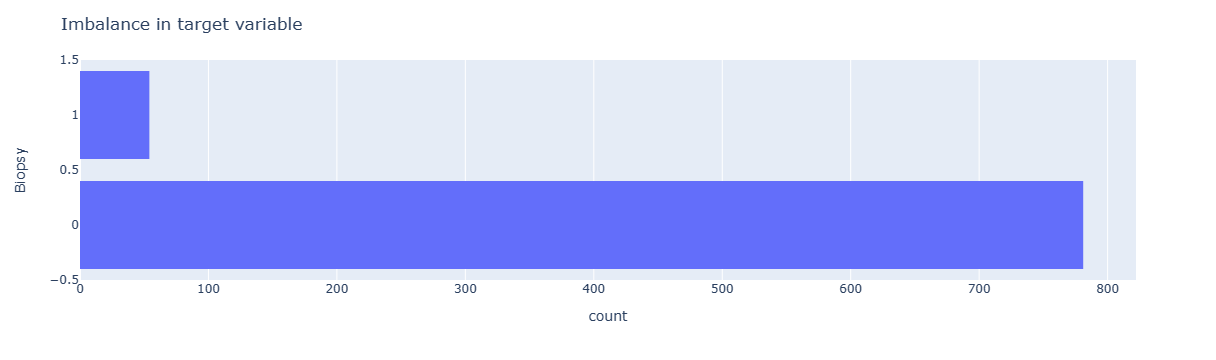

In [23]:
dx_cancer = px.histogram(df, y=target)
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Imbalance in target variable")
dx_cancer.show()

# SMOTE or ADASYN:
- Since we have a issues of imbalance data set, either Smote or Adasyn can be deployed to create synthetic data to balance the dataset
- ADASYN is used for now

In [24]:
X = df.drop([target, "age_cat"], axis=1)
y = df[target].copy()

In [25]:
# smote = SMOTE(random_state=42)
# x_smote, y_smote = smote.fit_resample(X, y)
# risk_factor_df = x_smote.join(y_smote)
# risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [26]:
adasyn = ADASYN(random_state=42)
X,y = adasyn.fit_resample(X,y)

In [27]:
X

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,total_std,total_tests
0,18,4.000000,15.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
1,15,1.000000,14.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
2,34,1.000000,17.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
3,52,5.000000,16.000000,4.000000,1.0,37.0,37.0,1.000000,3.000000,0.0,...,3.0,1,0,1,0,0,0,0,0.0,0
4,46,3.000000,21.000000,4.000000,0.0,0.0,0.0,1.000000,15.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,17,1.541296,13.623889,2.541296,0.0,0.0,0.0,1.000000,0.506607,0.0,...,3.0,0,0,0,0,0,0,0,0.0,2
1563,17,1.709061,15.545303,2.000000,0.0,0.0,0.0,0.290939,0.122195,0.0,...,3.0,0,0,0,0,0,0,0,0.0,1
1564,16,1.870969,14.612907,1.129031,0.0,0.0,0.0,0.129031,0.054193,0.0,...,3.0,0,0,0,0,0,0,0,0.0,2
1565,18,2.428174,15.570435,2.000000,0.0,0.0,0.0,1.000000,0.298605,0.0,...,3.0,0,0,0,0,0,0,0,0.0,1


In [28]:
new_to_csv=X
new_to_csv[target]=y

In [29]:
new_to_csv.to_csv("df_spark.csv", encoding='utf-8', index=False)

In [30]:
X = X.drop([target], axis=1)

In [31]:
X

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,total_std,total_tests
0,18,4.000000,15.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
1,15,1.000000,14.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
2,34,1.000000,17.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
3,52,5.000000,16.000000,4.000000,1.0,37.0,37.0,1.000000,3.000000,0.0,...,3.0,1,0,1,0,0,0,0,0.0,0
4,46,3.000000,21.000000,4.000000,0.0,0.0,0.0,1.000000,15.000000,0.0,...,3.0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,17,1.541296,13.623889,2.541296,0.0,0.0,0.0,1.000000,0.506607,0.0,...,3.0,0,0,0,0,0,0,0,0.0,2
1563,17,1.709061,15.545303,2.000000,0.0,0.0,0.0,0.290939,0.122195,0.0,...,3.0,0,0,0,0,0,0,0,0.0,1
1564,16,1.870969,14.612907,1.129031,0.0,0.0,0.0,0.129031,0.054193,0.0,...,3.0,0,0,0,0,0,0,0,0.0,2
1565,18,2.428174,15.570435,2.000000,0.0,0.0,0.0,1.000000,0.298605,0.0,...,3.0,0,0,0,0,0,0,0,0.0,1


# Train - test split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify = y, shuffle=True)#stratify = y

In [33]:
y_train.value_counts()

1    526
0    523
Name: Biopsy, dtype: int64

# PCA
- Principal Component Analysis is a method to reduce the dimenstion of larger dataset. This is used to increase performace. In this case 13 parameters can be used to explained 99% of the variable


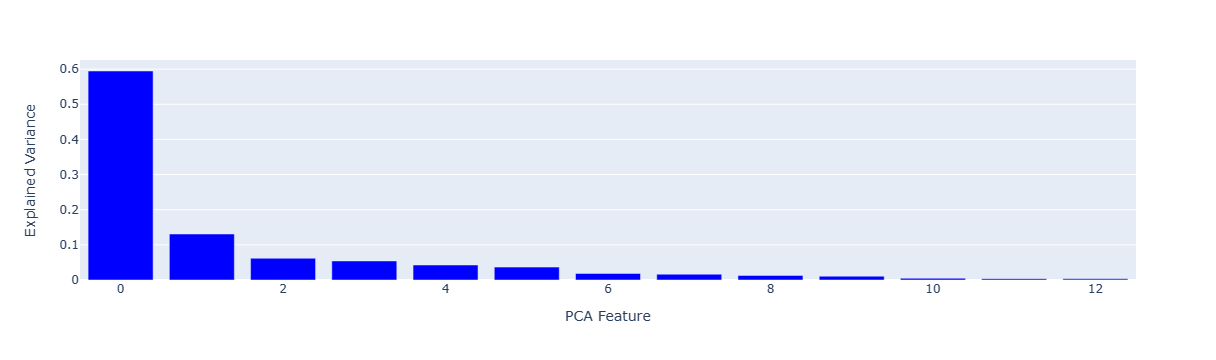

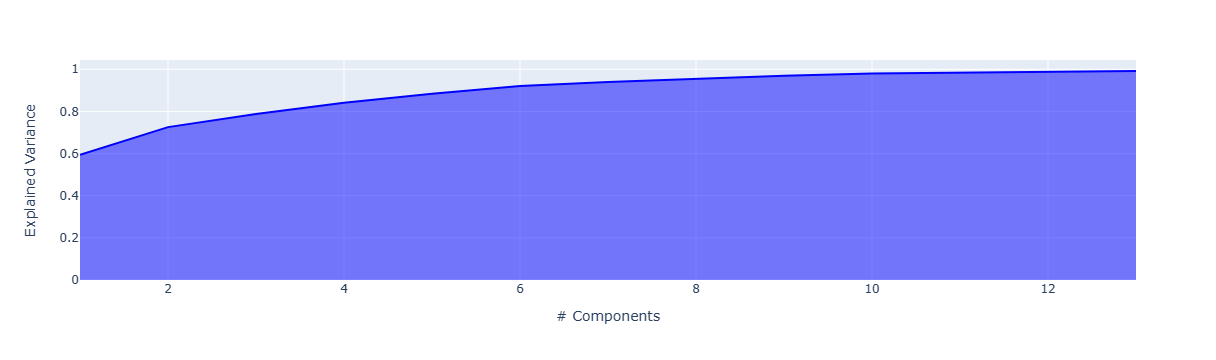

In [34]:
XT = RobustScaler().fit_transform(X_train)
pca = PCA(n_components=0.99)
XT = pca.fit_transform(XT)

dimensions = px.bar(x=range(pca.n_components_), y=pca.explained_variance_ratio_,
                    color_discrete_sequence=["blue"],
                    labels={"x":"PCA Feature","y":"Explained Variance"})
dimensions.show()
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

explained_variance = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    color_discrete_sequence=["blue"]
)
explained_variance.show()

# Model Application SkLearn
- 5 models are considered for this project
    - Logistic Regression
    - Random forest Classifier
    - KNeighbor Classifier
    - Support Vector Machine
    - CatBoost

In [35]:
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=13))
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [36]:
param_grid = {'C': np.logspace(-5, 8, 15)}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

In [37]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=2, n_jobs=-1,
                                 max_features="sqrt")

In [38]:
knn_clf = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 10, 2))}
knn_clf_cv = GridSearchCV(knn_clf, knn_param_grid, cv=10)

In [39]:
svm_clf = SVC()
svc_param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), }
svm_clf_cv = GridSearchCV(svm_clf, svc_param_grid, cv=5)

In [40]:
train_pool_CatBoost=Pool(X_train, y_train)
validation_pool_CatBoost = Pool(X_test, y_test)
cat_boost_model_done = fit_model(train_pool_CatBoost, validation_pool_CatBoost)

Learning rate set to 0.032066
0:	learn: 0.6536514	test: 0.6575531	best: 0.6575531 (0)	total: 148ms	remaining: 2m 28s
100:	learn: 0.0647846	test: 0.1185042	best: 0.1185042 (100)	total: 518ms	remaining: 4.61s
200:	learn: 0.0283755	test: 0.0925879	best: 0.0925354 (199)	total: 884ms	remaining: 3.51s
300:	learn: 0.0137537	test: 0.0842291	best: 0.0840862 (293)	total: 1.25s	remaining: 2.9s
400:	learn: 0.0081997	test: 0.0836515	best: 0.0836515 (400)	total: 1.62s	remaining: 2.42s
500:	learn: 0.0056308	test: 0.0856254	best: 0.0836299 (401)	total: 1.99s	remaining: 1.98s
600:	learn: 0.0043783	test: 0.0862869	best: 0.0836299 (401)	total: 2.36s	remaining: 1.56s
700:	learn: 0.0035008	test: 0.0875083	best: 0.0836299 (401)	total: 2.73s	remaining: 1.16s
800:	learn: 0.0030260	test: 0.0881869	best: 0.0836299 (401)	total: 3.1s	remaining: 770ms
900:	learn: 0.0027281	test: 0.0893831	best: 0.0836299 (401)	total: 3.46s	remaining: 381ms
999:	learn: 0.0025600	test: 0.0900143	best: 0.0836299 (401)	total: 3.82s	re

In [41]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []

estimators = [
    ("LogisticRegression", logreg_cv),
    ("RandomForestClassifier ", rnd_clf),
    ("KNeighborsClassifier", knn_clf_cv),
    ("SupportVectorClassifier", svm_clf_cv),
    ("CatBoost",cat_boost_model_done)]

for i in range(0, len(estimators)):
    clf_name = estimators[i][0]
    clf = estimators[i][1]
    if clf_name!="CatBoost":
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(pd.crosstab(y_test,y_pred,rownames=["Actual"],colnames=["predicted"],margins=True))
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))


summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score


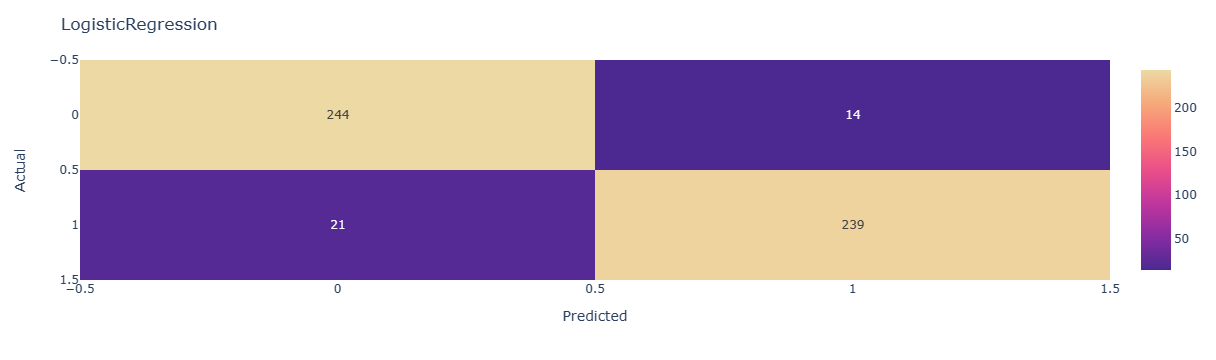

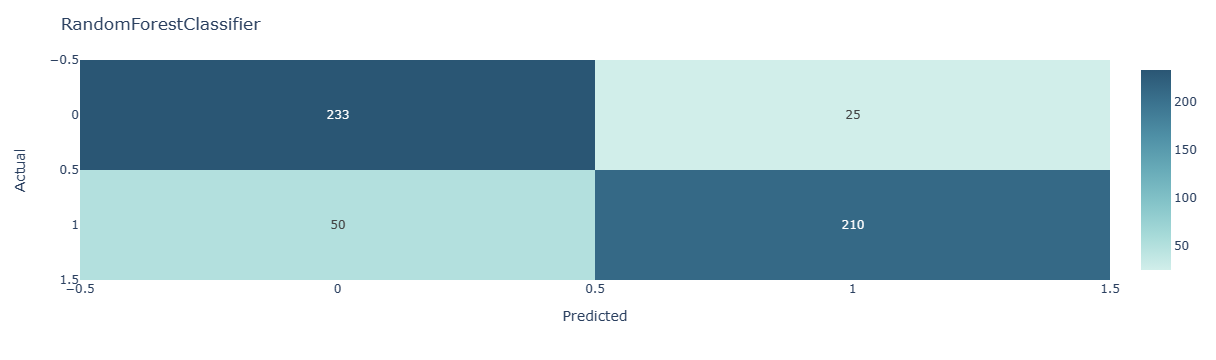

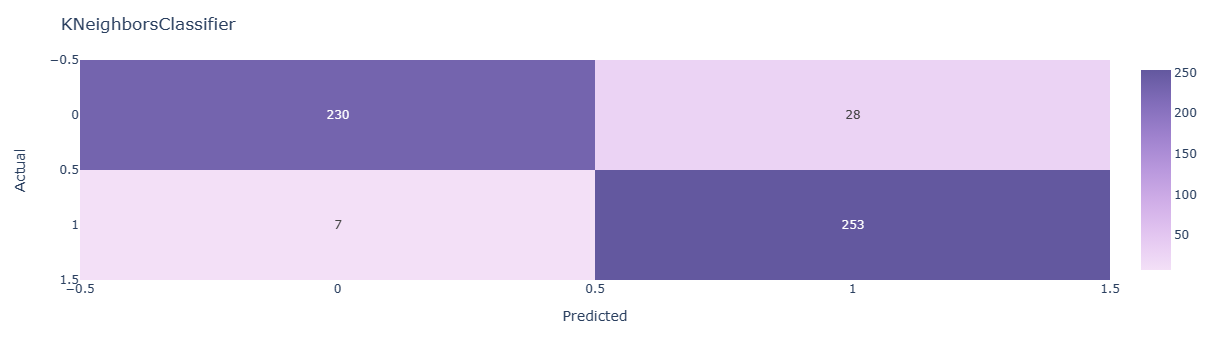

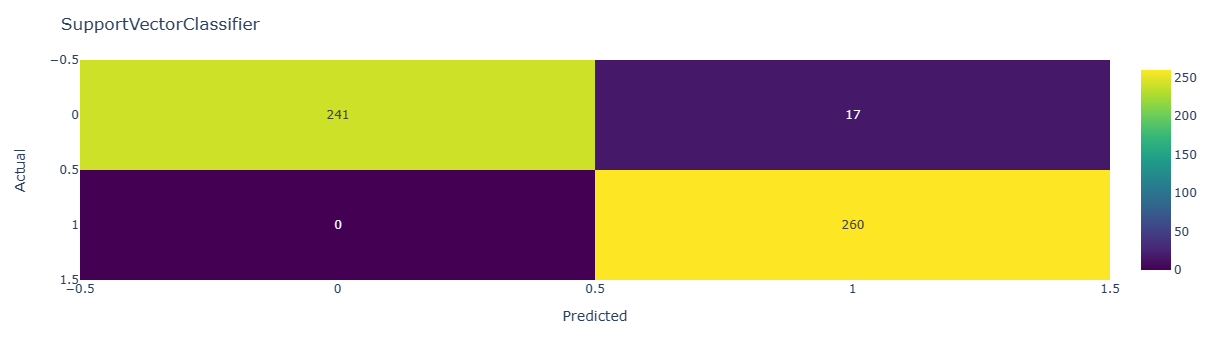

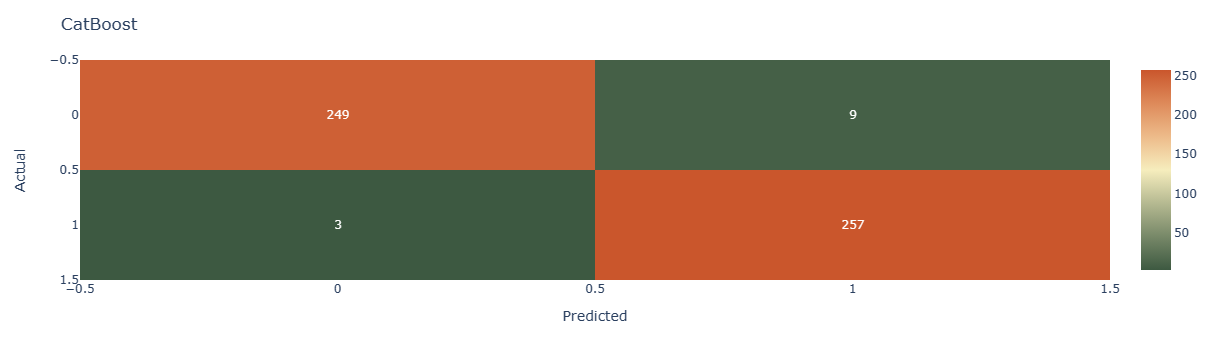

In [42]:
color_scales = ["agsunset","teal","purp","viridis","fall"]
for i in range(0,len(est_conf_matrix)):
    heatmap = px.imshow(est_conf_matrix[i],aspect="auto",
                        text_auto=True,
                        color_continuous_scale=color_scales[i])
    heatmap.update_layout(title = est_name[i])
    heatmap.update_xaxes(title="Predicted")
    heatmap.update_yaxes(title="Actual")
    heatmap.show()

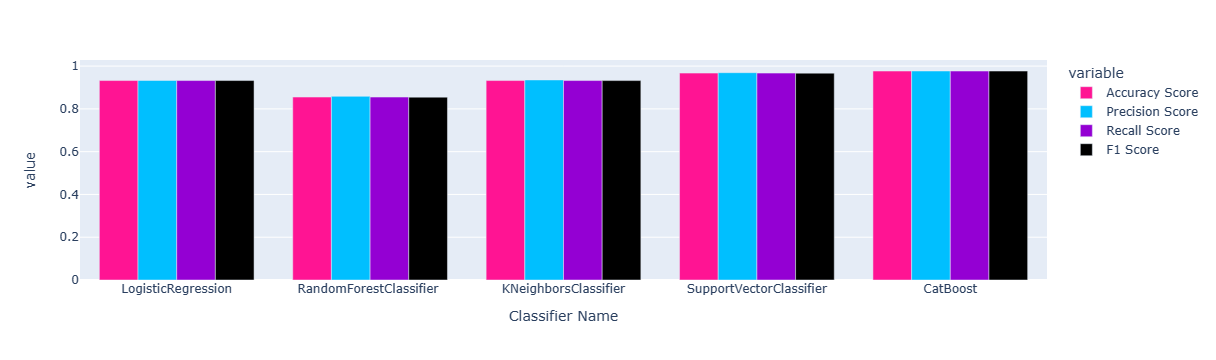

In [43]:
acc_comparison = px.bar(summary_df, x="Classifier Name",
                        y=col_names[1:len(col_names)],
                        color_discrete_sequence=["deeppink",
                                                 "deepskyblue",
                                                 "darkviolet",
                                                 "black"],
                        barmode="group")
acc_comparison.show()

# Application Spark
Spark tend to perform faster when reading from csv compared to using pandas dataframe thus, the X and y df has been made into X and y csv file

In [44]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ThuanSession').getOrCreate()

In [45]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [46]:
df_spark = spark.read.options(inferSchema="true", header="true").csv("df_spark.csv")

In [47]:
df_spark.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Number of sexual partners: double (nullable = true)
 |-- First sexual intercourse: double (nullable = true)
 |-- Num of pregnancies: double (nullable = true)
 |-- Smokes: double (nullable = true)
 |-- Smokes (years): double (nullable = true)
 |-- Smokes (packs/year): double (nullable = true)
 |-- Hormonal Contraceptives: double (nullable = true)
 |-- Hormonal Contraceptives (years): double (nullable = true)
 |-- IUD: double (nullable = true)
 |-- IUD (years): double (nullable = true)
 |-- STDs: double (nullable = true)
 |-- STDs (number): double (nullable = true)
 |-- STDs:condylomatosis: double (nullable = true)
 |-- STDs:cervical condylomatosis: double (nullable = true)
 |-- STDs:vaginal condylomatosis: double (nullable = true)
 |-- STDs:vulvo-perineal condylomatosis: double (nullable = true)
 |-- STDs:syphilis: double (nullable = true)
 |-- STDs:pelvic inflammatory disease: double (nullable = true)
 |-- STDs:genital herpes: double (nulla

## Create Features columns to ready the data for regression

In [48]:
Assembler=VectorAssembler(inputCols=df_spark.columns[:-1],
                           outputCol='features')
df_spark=Assembler.transform(df_spark)

In [49]:
df_train_test_spark=df_spark.select('features',target)

In [50]:
df_train_test_spark.show()

+--------------------+------+
|            features|Biopsy|
+--------------------+------+
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,4,5,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,4,5,...|     1|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,26,2...|     0|
|(37,[0,1,2,3,4,5,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,9,10...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,7,8,...|     0|
|(37,[0,1,2,3,9,10...|     0|
+--------------------+------+
only showing top 20 rows



# Spark Model applciations
- Classification models chosen:
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Gradient Boosted Classifier
    - Linear Support Vector Machine
    - Naives Bayes
    - Factorization Machine Classifier

In [51]:
from pyspark.sql.functions import rand 
from pyspark.ml.classification import LogisticRegression as LogisticRegression_Spark
from pyspark.ml.classification import DecisionTreeClassifier as DecisionTreeClassifier_Spark
from pyspark.ml.classification import RandomForestClassifier as RandomForestClassifier_Spark
from pyspark.ml.classification import GBTClassifier as GBTClassifier_Spark
from pyspark.ml.classification import LinearSVC as LinearSVC_Spark
from pyspark.ml.classification import NaiveBayes as NaiveBayes_Spark
from pyspark.ml.classification import FMClassifier as FMClassifier_Spark
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier


In [52]:
model_list=[]
model_list.append(("LogRegression",LogisticRegression_Spark(featuresCol="features", labelCol=target)))
model_list.append(("DecTree",DecisionTreeClassifier_Spark(featuresCol="features", labelCol=target)))
model_list.append(("RandomForrest",RandomForestClassifier_Spark(featuresCol="features", labelCol=target)))
model_list.append(("GBTClassifier",GBTClassifier_Spark(featuresCol="features", labelCol=target)))
model_list.append(("LinearSVC",LinearSVC_Spark(featuresCol="features", labelCol=target)))
model_list.append(("NaiveBayes",NaiveBayes_Spark(featuresCol="features", labelCol=target)))
model_list.append(("FMClassifier",FMClassifier_Spark(featuresCol="features", labelCol=target)))



In [53]:
import timeit
folds=10 # Number of times the data is being shuffled

performance_metrics=['accuracy','precisionByLabel','recallByLabel','f1']
cols_name=['Name','itteration']

for  p in performance_metrics:
    cols_name.append(p)
cols_name.append('time(s)')
performance_df_spark = pd.DataFrame(columns = cols_name)



for itteration in range(folds):
    #print(itteration)
    df_shuffle=df_train_test_spark.orderBy(rand())
    trainDF,testDF=df_shuffle.randomSplit([0.75,0.25])
    
    #Handle all normal model
    for model in model_list:
        start_time = timeit.default_timer()
        cur_model=model[1]
        cur_model=cur_model.fit(trainDF)
        pred=cur_model.transform(testDF)
        temp = [model[0],itteration]
        
        for p in performance_metrics:
            evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target, metricName=p)
            temp.append(evaluator.evaluate(pred))
            
        end_time=timeit.default_timer()-start_time
        
        temp.append(end_time)
        performance_df_spark.loc[len(performance_df_spark.index)] = temp
    
    #Handle multilayer perceptron
    layers=[37,38,37,2]
    
    start_time = timeit.default_timer()
    
    trainer = MultilayerPerceptronClassifier(maxIter=100,layers=layers,blockSize=128,labelCol=target)
    model=trainer.fit(trainDF)
    pred=model.transform(testDF)
    temp = ['MultiLayerPerceptron',0]
    
    for p in performance_metrics:
        evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target, metricName=p)
        temp.append(evaluator.evaluate(pred))
    
    end_time=timeit.default_timer()-start_time
    temp.append(end_time)
    performance_df_spark.loc[len(performance_df_spark.index)] = temp
    

In [54]:
avg_df=performance_df_spark.groupby('Name',as_index=False)[performance_metrics].mean()

In [55]:
acc_comparison = px.bar(avg_df, x="Name",
                        y=performance_metrics,
                        barmode="group")
acc_comparison.show()

In [56]:
px.bar(performance_df_spark.groupby('Name',as_index=False)['time(s)'].mean(),x="Name",y=["time(s)"],color='Name')

In [57]:
performance_df_spark.groupby('Name',as_index=False).mean()

,Name,itteration,accuracy,precisionByLabel,recallByLabel,f1,time(s)
0,DecTree,4.5,0.989524,0.997455,0.981249,0.989523,1.111416
1,FMClassifier,4.5,0.983527,0.990821,0.975641,0.983524,2.488873
2,GBTClassifier,4.5,0.991472,0.997923,0.984716,0.991470,4.433797
3,LinearSVC,4.5,0.999750,1.000000,0.999510,0.999750,1.539962
4,LogRegression,4.5,1.000000,1.000000,1.000000,1.000000,1.770041
5,MultiLayerPerceptron,0.0,0.987283,0.996418,0.977614,0.987281,3.353004
6,NaiveBayes,4.5,0.895960,0.907245,0.878785,0.895909,0.650592
7,RandomForrest,4.5,0.979637,1.000000,0.958761,0.979622,1.175428


In [58]:
performance_df_spark

,Name,itteration,accuracy,precisionByLabel,recallByLabel,f1,time(s)
0,LogRegression,0,1.000000,1.000000,1.000000,1.000000,6.758764
1,DecTree,0,0.987469,1.000000,0.975490,0.987470,2.893698
2,RandomForrest,0,0.984962,1.000000,0.970588,0.984964,2.193783
3,GBTClassifier,0,0.994987,1.000000,0.990196,0.994988,6.100488
4,LinearSVC,0,1.000000,1.000000,1.000000,1.000000,2.969071
...,...,...,...,...,...,...,...
75,GBTClassifier,9,0.989770,1.000000,0.980100,0.989772,3.878143
76,LinearSVC,9,1.000000,1.000000,1.000000,1.000000,1.393236
77,NaiveBayes,9,0.902813,0.917949,0.890547,0.902832,0.442950
78,FMClassifier,9,0.976982,0.980000,0.975124,0.976984,2.104189
